![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)

Find this notebook in https://colab.research.google.com/github/ricardokleinklein/NLP_GenMods/blob/main/fake_news.ipynb

# Modelos Generativos

## Detección de Fake News - NLP

Creado por *Ricardo Kleinlein* para [Saturdays.AI](https://saturdays.ai/).

Disponible bajo una licencia [Creative Commons](https://creativecommons.org/licenses/by/4.0/).

---

## Sobre el uso de Jupyter Notebooks

Este notebook ha sido implementado en Python, pero para su ejecución no es
necesario conocer el lenguaje en profundidad. Solamente se debe ejecutar cada
una de las celdas, teniendo en cuenta que hay que ejecutar una celda a la vez
y secuencialmente, tal y como figuran en orden de aparición.

Para ejecutar cada celda pulse en el botón ▶ en la esquina superior izquierda
de cada celda. Mientras se esté ejecutando ese fragmento de código,
el botón estará girando. En caso de querer detener dicha ejecución, pulse
nuevamente sobre este botón mientras gira y la ejecución se detendrá. En caso
de que la celda tenga alguna salida (texto, gráficos, etc) será mostrada
justo después de esta y antes de mostrar la siguiente celda. El notebook
estará guiado con todas las explicaciones necesarias, además irá acompañado
por comentarios en el código para facilitar su lectura.

En caso de tener alguna duda, anótela. Dedicaremos un tiempo a plantear y
resolver la mayoría delas dudas que puedan aparecer.


## Objetivo del notebook

Implementar, entrenar y evaluar un modelo de predicción de noticias falsas
relacionadas con la pandemia de la COVID-19 en inglés.

## Importamos las librerías

In [1]:
import pandas
import numpy
import torch
import matplotlib.pyplot as plt

%matplotlib inline
!ls

sample_data  tweets_test.csv  tweets_train.csv


## Accedemos a la base de datos

Si la celda inferior fallara, podemos subir el archivo manualmente a Google
Colab.

In [2]:
df_train = pandas.read_csv('./tweets_train.csv')
df_test = pandas.read_csv('./tweets_test.csv')

def news_iterator(tweets, labels):
    for tweet, label in zip(tweets, labels):
        yield (label, tweet)

train_iter = news_iterator(df_train['tweet'].values, df_train['label'].values)
test_iter = news_iterator(df_test['tweet'].values, df_test['label'].values)


## Qué aspecto tienen los datos?

Al ser una clasificación binaria (real / fake), solo van a existir 2
categorías.

In [3]:
print(df_train.head(5))
df_train['label'].describe()

   id                                              tweet label
0   1  The CDC currently reports 99031 deaths. In gen...  real
1   2  States reported 1121 deaths a small rise from ...  real
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake
3   4  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4   5  Populous states can generate large case counts...  real


count     6420
unique       2
top       real
freq      3360
Name: label, dtype: object

In [4]:
print(df_test.head(5))
df_test['label'].describe()

   id                                              tweet label
0   1  Our daily update is published. States reported...  real
1   2             Alfalfa is the only cure for COVID-19.  fake
2   3  President Trump Asked What He Would Do If He W...  fake
3   4  States reported 630 deaths. We are still seein...  real
4   5  This is the sixth time a global health emergen...  real


count     2140
unique       2
top       real
freq      1120
Name: label, dtype: object

Como vemos, es una tarea en la que las etiquetas están bastante equilibradas
 (52% de verdaderas, 48% de noticias falsas), convirtiendo el problema en un
  caso estándar susceptible de ser atacado mediante machine learning.

## Preprocesado

Como hemos comentado en otro notebook, un paso fundamental consiste en
tokenizar nuestras palabras y construir con ello un vocabulario de nuestra
tarea.

In [5]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

Con este procesado pasamos de palabras a una lista de índices:

In [6]:
vocab(['here', 'is', 'an', 'instance'])

[142, 10, 65, 17852]

Vamos ahora a preparar de terminar el pipeline de entrada de texto, junto
con la entrada del label de cada muestra.

In [7]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 0 if x == 'fake' else 1

Esto es en realidad una look-up table definida por la manera de construir
nuestro vocabulario. Igualmente, convertimos las etiquetas en un índice, en
lugar de su forma original.

In [8]:
print(text_pipeline('here is a new instance'))
print(label_pipeline('fake'))

[142, 10, 8, 22, 17852]
0


## Generar batches e iterador

In [9]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

## Definimos el modelo a usar

Vamos a emplear un modelo muy sencillo, para poder entrenarlos de cero por nosotros mismos.

![modelo texto](https://github.com/ricardokleinklein/NLP_GenMods/blob/main/assets/fake_news_model.png?raw=1)

In [10]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [11]:
model = TextClassificationModel(vocab_size=len(vocab), embed_dim=64,
                                num_class=2).to(device)

## Definir la función de entrenamiento y evaluación

In [12]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    accumulated_loss = []

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        accumulated_loss.append(loss)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
    return torch.mean(torch.stack(accumulated_loss))

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    accumulated_loss = []

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            accumulated_loss.append(loss)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count, torch.mean(torch.stack(accumulated_loss))



In [25]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 50 # epoch
LR = 1e-2  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

total_accu = None

train_iter = news_iterator(df_train['tweet'].values, df_train['label'].values)
test_iter = news_iterator(df_test['tweet'].values, df_test['label'].values)

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.7)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)
train_loss = []
val_loss = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_loss.append(train(train_dataloader))
    accu_val, loss_val = evaluate(valid_dataloader)
    val_loss.append(loss_val)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


-----------------------------------------------------------
| end of epoch   1 | time:  0.72s | valid accuracy    0.522 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  0.72s | valid accuracy    0.522 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  0.70s | valid accuracy    0.522 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  0.69s | valid accuracy    0.522 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  0.68s | valid accuracy    0.522 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  0.69s |

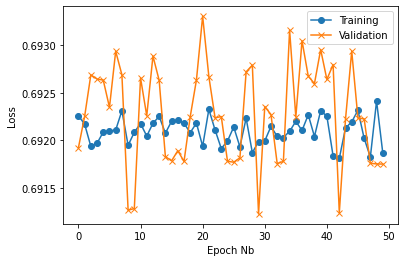

In [26]:
train_loss = [x.cpu().detach().numpy() for x in train_loss]
val_loss = [x.cpu().detach().numpy() for x in val_loss]
plt.plot(train_loss, marker='o')
plt.plot(val_loss, marker='x')
plt.xlabel('Epoch Nb')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

In [23]:
print('Checking the results of test dataset.')
accu_test, _ = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.579


## Trabajo adicional

Existen muchas maneras de elaborar sobre las ideas presentadas en este notebook. Desde modificar los hiperparámetros de la red (número de capas, número de neuronas por capa, arquitectura) a cambiar los parámetros del entrenamiento: learning rate, epochs...

A continuación se presenta preparada la arquitectura para dos modelos ligeramente diferentes al probado, para dar una idea del efecto de ciertos cambios en la arquitectura de modelos deep learning.

In [24]:
# Este modelo procesa el input con un número variable de capas intermedias FC.

class BiLayerTextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class, num_layers):
        super(BiLayerTextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for i in range(num_layers)])
        self.last_fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        #[layer.weight.data.uniform_(-initrange, initrange) for layer in self.fc]
        #[layer.bias.data.zero_() for layer in self.fc]
        self.last_fc.weight.data.uniform_(-initrange, initrange)
        self.last_fc.bias.data.zero_()

    def forward(self, text, offsets):
        z = self.embedding(text, offsets)
        for l, layer in enumerate(self.fc):
          z = layer(z)
        return self.last_fc(z)

model = BiLayerTextClassificationModel(vocab_size=len(vocab), embed_dim=64,
                                num_class=2, num_layers=10).to(device)